# CORD-19 citation network analysis

In this notebook, we build a bibliographic coupling citation network of the publications we could match in Dimensions, and perform clustering using the Leiden algorithm. We export cluster partition information, as well as global and local (cluster-specific) centrality measures to use in the regression analysis.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

# magics and warnings
%load_ext autoreload
%autoreload 2
import warnings; warnings.simplefilter('ignore')

import os, random, codecs, time, pickle
import ujson as json
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

seed = 99
random.seed(seed)
np.random.seed(seed)

import nltk, sklearn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})

In [3]:
# dataset Dimensions: source of citation data

json_sources = "../cwts_covid/datasets_output/json_dimensions_cwts"

In [4]:
# build networks and node metadata
# this requires Dimensions data, downloaded following: https://github.com/CWTSLeiden/cwts_covid

from collections import OrderedDict
import sys

metadata = list()
metadata_dict = dict()
citations = OrderedDict()
total_publications = 0

for root, dirs, files in os.walk(json_sources):
    for f in files:
        all_data = codecs.open(os.path.join(root,f)).read()
        for line in all_data.split("\n"):
            total_publications += 1
            if line:
                try:
                    data = json.loads(line)
                    if "references" in data.keys() and len(data["references"])>0: # filter out papers without outbound citations
                        title = ""
                        year = ""
                        doi = ""
                        pmid = ""
                        d_id = ""
                        times_cited = ""
                        journal = ""
                        if "title" in data.keys() and data["title"]:
                            title = data["title"].replace('"',"")
                        if "journal" in data.keys() and "title" in data["journal"].keys() and data["journal"]["title"]:
                            jorunal = data["journal"]["title"]
                        if "year" in data.keys() and data["year"]:
                            year = str(data["year"])
                        if "doi" in data.keys() and data["doi"]:
                            doi = data["doi"]
                        if "pmid" in data.keys() and data["pmid"]:
                            doi = str(data["pmid"])
                        if "id" in data.keys() and data["id"]:
                            d_id = str(data["id"])
                        if "times_cited" in data.keys():
                            times_cited = str(data["times_cited"])
                        metadata.append((d_id,'"'+title+'"',year,'"'+doi+'"',pmid,'"'+journal+'"',times_cited))
                        metadata_dict[d_id] = {"title":title,"year":year,"doi":doi,"journal":journal,"times_cited":times_cited,
                                                    "pmid":pmid,"d_id":d_id}
                        citations[data["id"]] = data["references"]
                except ValueError:
                    print("Could not convert data.")
                except:
                    print(line)
                    continue

In [5]:
len(citations)

48571

In [6]:
total_publications

59463

In [8]:
# create bibc network
# this is a super naive method, and takes a while

bibc_edge_list = list()
items = [(k,v) for k,v in citations.items()]

for n,(k1,v1) in tqdm(enumerate(items)):
    for k2,v2 in items[n+1:]:
        edge_weight = len(set(v2).intersection(set(v1))) / len(set(v2).union(set(v1))) # fractional edge weight
        if edge_weight > 0:
            bibc_edge_list.append((k1,k2,str(edge_weight)))

In [9]:
# export in csv (optional)

with open("data/bib_coupling_edgelist_norm.csv","w") as f:
    f.write("Source,Target,Weight\n")
    for edge in bibc_edge_list:
        #if float(edge[2])>1:
        f.write(",".join(edge)+"\n")

In [10]:
with open("data/bib_coupling_nodelist.csv","w") as f:
    f.write("ID,Title,Year,DOI,PMID,Journal,Times_cited\n")
    for node in metadata:
        f.write(",".join(node)+"\n")

In [11]:
len(bibc_edge_list)

17087380

In [12]:
weight_list = [float(x[2]) for x in bibc_edge_list if float(x[2])>0]

In [13]:
np.median(weight_list)

0.014925373134328358

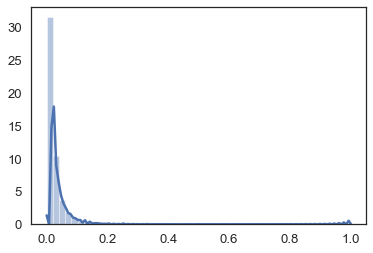

In [14]:
sns.distplot(weight_list)

In [15]:
# create an igraph graph

import igraph as ig
ig.set_random_number_generator(random.seed(seed))

In [16]:
g = ig.Graph(directed=False)

In [17]:
edges = [(int(k[0].replace("pub.","")),int(k[1].replace("pub.",""))) for k in bibc_edge_list]
nodes = list(set([k[0] for k in edges]).union(set([k[1] for k in edges])))
weights = [float(k[2]) for k in bibc_edge_list]

In [18]:
# mapping of nodes to identifiers

node_map = {k:n for n,k in enumerate(nodes)}
edges_int = [(node_map[k[0]],node_map[k[1]]) for k in edges]
nodes_int = [node_map[k] for k in nodes]

In [19]:
len(node_map)

47706

In [20]:
"There are "+str(len(citations)-len(node_map))+" disconnected publications (with references)"

'There are 865 disconnected publications (with references)'

In [21]:
inverse_node_map = {n:k for k,n in node_map.items()}

In [22]:
# add nodes and edges

g.add_vertices(nodes_int)
g.add_edges(edges_int)
g.es["weight"] = weights
g.vs["weight"] = 1
g.vs["dimensions_id"] = nodes

In [23]:
# clustering 
import leidenalg as la

In [24]:
h = g.components(mode='weak').giant()

In [50]:
len(h.vs)

47612

In [25]:
# 0.05 seems to find a relatively high modularity and reasonable sized clusters. Lowering it brings up one or two large clusters.

partition = la.find_partition(h, la.CPMVertexPartition, resolution_parameter = 0.05)

In [26]:
partition.quality()

17127582.899999123

In [27]:
partition.q

0.3619187844833918

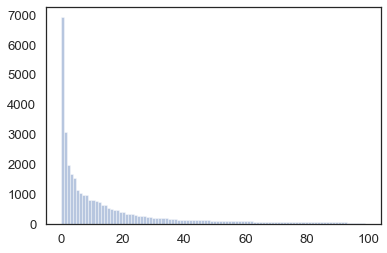

In [45]:
# distribution of the size of clusters

sns.distplot([x for x in partition.membership if x<100], norm_hist=False, kde=False, bins=100)
plt.savefig("figures/nb4_cluster_size_distr.pdf")

In [29]:
from collections import Counter

c = Counter(partition.membership)

In [30]:
len(c)

2039

In [31]:
c.most_common(10)

[(0, 6917),
 (1, 3082),
 (2, 1989),
 (3, 1693),
 (4, 1558),
 (5, 1151),
 (6, 1043),
 (7, 986),
 (8, 970),
 (9, 808)]

In [32]:
cluster_sizes = {c:s for c,s in c.most_common()}

In [ ]:
# add note attributes and calculate indicators. This takes some time to compute

In [33]:
h.vs['cluster_id'] = partition.membership
h.vs['cluster_above_threshold'] = False
h.vs['cluster_size'] = [cluster_sizes[x] for x in partition.membership]

In [34]:
h.vs['global_degree'] = h.degree()

In [35]:
h.vs['global_pagerank'] = h.pagerank(directed=False, weights='weight')

In [ ]:
# TODO: actually calculate closeness (and betweenness)

In [36]:
# using a cutoff here
#h.vs['global_closeness'] = h.closeness(weights='weight')
h.vs['global_closeness'] = np.nan

In [37]:
# cluster-specific indicators
h.vs['local_degree'] = np.nan
h.vs['local_pagerank'] = np.nan
h.vs['local_closeness'] = np.nan

In [38]:
threshold = 100 # we only calculate indicators for nodes in clusters of size equal of greater than this threshold!

for cluster in c.most_common():
    c_id = cluster[0]
    c_size = cluster[1]
    if c_size >= threshold:
        t = partition.subgraph(c_id)
        t.vs['local_degree'] = t.degree()
        t.vs['local_pagerank'] = t.pagerank(directed=False, weights='weight')
        #t.vs['local_closeness'] = t.betweenness(directed=False, cutoff=100, weights='weight')
        for v in t.vs:
            #print(v)
            h.vs.find(dimensions_id=v['dimensions_id'])['local_degree'] = v['local_degree']
            h.vs.find(dimensions_id=v['dimensions_id'])['local_pagerank'] = v['local_pagerank']
            #h.vs.find(dimensions_id=v['dimensions_id'])['local_closeness'] = v['local_closeness']
            h.vs.find(dimensions_id=v['dimensions_id'])['cluster_above_threshold'] = True

In [39]:
# create and export a data frame
df_network = pd.DataFrame.from_dict({"dimensions_id": ["pub."+str(i) for i in h.vs['dimensions_id']],
                                     "cluster_id": h.vs['cluster_id'],
                                     "cluster_above_threshold": h.vs['cluster_above_threshold'],
                                     "cluster_size": h.vs['cluster_size'],
                                     "global_degree": h.vs['global_degree'],
                                     "global_pagerank": h.vs['global_pagerank'],
                                     "global_closeness": h.vs['global_closeness'],
                                     "local_degree": h.vs['local_degree'],
                                     "local_pagerank": h.vs['local_pagerank'],
                                     "local_closeness": h.vs['local_closeness']})
df_network.to_csv("data/df_network.csv", index=False, compression="gzip")

In [40]:
# graph of clusters (optional)

H = partition.cluster_graph(combine_vertices={'weight': 'sum'},
                                                 combine_edges={'weight': 'mean'})
H.write("data/network_of_clusters.graphml",format="graphml")

### Plots

In [41]:
df_topic_intensity = pd.read_csv("data/df_topic_intensity.csv", compression="gzip")
df_joined_all = pd.read_csv("data/df_joined_all.csv", compression="gzip")

In [42]:
df_topic_intensity.head()

,Coronavirus outbreaks,Public health,Epidemics,Animal transmission,Molecular biology,Respiratory diseases,Immunology,Systematic reviews,Diagnosing,year,doi,pub_id
0,0.200656,0.472949,0.246007,0.054535,0.0,0.000000,0.018858,0.000000,0.000000,2020.0,0.1126/science.abb7331,0
1,0.256909,0.000000,0.000000,0.000000,0.0,0.000000,0.315510,0.347541,0.000000,2020.0,10.0376/cma.j.issn.0376-2491.2020.0002,1
2,0.000000,0.012961,0.000000,0.000000,0.0,0.982300,0.000000,0.000000,0.000000,2008.0,10.1001/archinte.168.22.2489,2
3,0.000000,0.026788,0.000000,0.024880,0.0,0.913815,0.015020,0.000000,0.016966,2010.0,10.1001/jama.2010.675,3
4,0.322807,0.000000,0.000000,0.097959,0.0,0.279916,0.246759,0.000000,0.000000,2014.0,10.1001/jama.2014.2116,4


In [43]:
df_topic_intensity.columns

Index(['Coronavirus outbreaks', 'Public health', 'Epidemics',
       'Animal transmission', 'Molecular biology', 'Respiratory diseases',
       'Immunology', 'Systematic reviews', 'Diagnosing', 'year', 'doi',
       'pub_id'],
      dtype='object')

In [44]:
topic_labels = ['Coronavirus outbreaks', 'Public health', 'Epidemics',
       'Animal transmission', 'Molecular biology', 'Respiratory diseases',
       'Immunology', 'Systematic reviews', 'Diagnosing']

In [56]:
df_embeddings = df_network.merge(df_joined_all[["pub_id","id","in_wikipedia","title"]], how="inner", left_on="dimensions_id", right_on="id")

In [57]:
df_embeddings.shape

(45809, 14)

In [58]:
df_embeddings = df_embeddings.merge(df_topic_intensity, how="inner", left_on="pub_id", right_on="pub_id")

In [59]:
df_topic_intensity.shape

(61482, 12)

In [60]:
df_embeddings.shape

(45809, 25)

In [135]:
df_embeddings.head()

,dimensions_id,cluster_id,cluster_above_threshold,cluster_size,global_degree,global_pagerank,global_closeness,local_degree,local_pagerank,local_closeness,...,Public health,Epidemics,Animal transmission,Molecular biology,Respiratory diseases,Immunology,Systematic reviews,Diagnosing,year,doi
0,pub.1121976320,166,False,26,32,0.000007,NaN,NaN,NaN,NaN,...,0.064922,0.553747,0.000000,0.013632,0.000000,0.033991,0.237440,0.092494,2019.0,10.3390/s19204561
1,pub.1103626240,19,True,418,259,0.000010,NaN,145.0,0.002265,NaN,...,0.000000,0.059216,0.185718,0.249018,0.000000,0.258568,0.122377,0.093511,2018.0,10.1038/s41413-018-0014-y
2,pub.1038352402,5,True,1151,551,0.000015,NaN,295.0,0.000647,NaN,...,0.052206,0.913912,0.000000,0.000000,0.000000,0.000000,0.025135,0.000000,2009.0,10.1155/2009/591935
3,pub.1026031634,2,True,1989,599,0.000021,NaN,386.0,0.000546,NaN,...,0.076900,0.000000,0.000000,0.000000,0.703958,0.182915,0.000000,0.023946,2016.0,10.1371/journal.pone.0152015
4,pub.1032847387,53,True,105,100,0.000007,NaN,19.0,0.007314,NaN,...,0.114310,0.000000,0.272439,0.527672,0.000000,0.042534,0.000000,0.031690,2010.0,10.1111/j.1365-2567.2010.03277.x


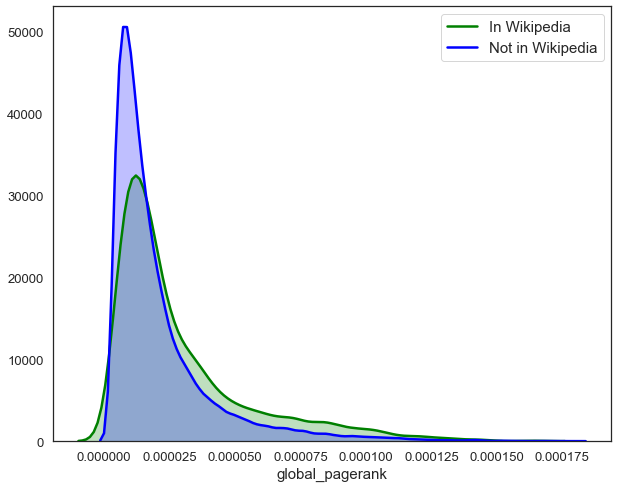

In [141]:
# distribution of centralities for papers cited from Wikipedia or not

which_centrality = "global_pagerank"

plt.figure(figsize=(10,8))
sns.distplot(df_embeddings[df_embeddings.in_wikipedia==True][which_centrality].values, color="green", kde=True, norm_hist=True, kde_kws={"shade": True}, hist=False, label="In Wikipedia")
sns.distplot(df_embeddings[df_embeddings.in_wikipedia==False][which_centrality].values, color="blue", kde=True, norm_hist=True, kde_kws={"shade": True}, hist=False, label="Not in Wikipedia")
plt.legend(fontsize=15)
plt.xlabel("%s"%which_centrality,fontsize=15)
plt.savefig("figures/nb4_%s_in_wiki.pdf"%which_centrality)

In [142]:
# plot cluster % of papers cited from Wikipedia, against cluster size

In [153]:
cluster_coverage = list()
cluster_size = list()
cluster_number = list()
below_threshold_size = 0
below_threshold_coverage = 0
#local_threshold = threshold
threshold = 500

# also calculate paper centralities wrt. cluster centroid
# for every paper, this is 1 - the (cosine) distance wrt. its centroid
# we need both similarity and args to index results

for cl in c.most_common():
    cl_size = cl[1]
    inw = df_embeddings[(df_embeddings.in_wikipedia==True)&(df_embeddings.cluster_id==cl[0])].shape[0]
    if cl[1]>threshold:
        coverage = inw/cl_size
        cluster_coverage.append(coverage)
        cluster_size.append(cl_size)
        cluster_number.append(cl[0])
    else:
        below_threshold_coverage += inw
        below_threshold_size += cl_size
#cluster_coverage.append(below_threshold_coverage/below_threshold_size)
#cluster_size.append(below_threshold_size)
#cluster_number.append(-1)

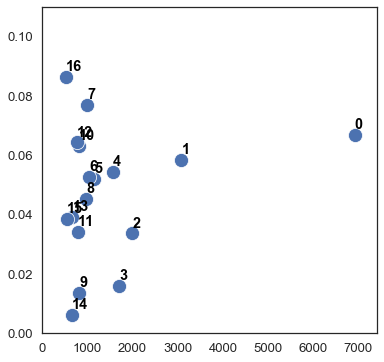

In [154]:
plt.figure(figsize=(6,6))
pl = sns.scatterplot(x=cluster_size,y=cluster_coverage,s=200)
# add annotations one by one with a loop
for dot in cluster_number:
     pl.text(cluster_size[dot]+7, cluster_coverage[dot]+0.002, s=cluster_number[dot], horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.ylim((0,0.11))
plt.xlim((0,max(cluster_size)+500))
#plt.legend(fontsize=15)
plt.savefig("figures/nb4_cluster_size_vs_wiki_coverage_%d_no_max.pdf"%local_threshold)

In [189]:
which_cluster = 1

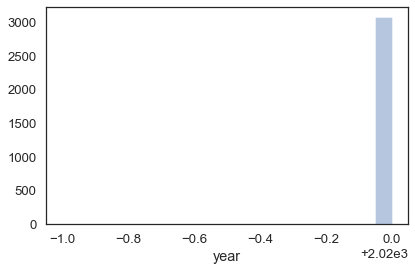

In [190]:
sns.distplot(df_embeddings[df_embeddings.cluster_id==which_cluster].year, bins=20, kde=False)
plt.tight_layout()
plt.savefig("figures/nb4_cluster_%d_yeardistr.pdf"%(which_cluster))

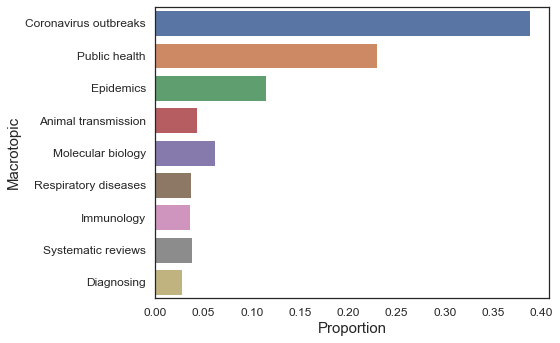

In [191]:
plt.figure(figsize=(8,5))
df_sub = df_embeddings[df_embeddings.cluster_id == which_cluster][[mt for mt in topic_labels]].mean()
b = sns.barplot(y=df_sub.index,x=df_sub.values)
#b.axes.set_title("Title",fontsize=50)
b.set_xlabel("Proportion",fontsize=15)
b.set_ylabel("Macrotopic",fontsize=15)
#b.set_title("Clustering")
b.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig("figures/nb4_cluster_%d_to_topicmodel.pdf"%(which_cluster))

In [192]:
# examples of central papers in a cluster

df_embeddings[["dimensions_id","cluster_id","cluster_size","global_degree","global_pagerank","title","year"]][df_embeddings.cluster_id==which_cluster].sort_values("global_pagerank",ascending=False).head(20)

,dimensions_id,cluster_id,cluster_size,global_degree,global_pagerank,title,year
40497,pub.1125880149,1,3082,4591,0.000152,Analysis of 2019 Novel Coronavirus Infection a...,2020.0
43330,pub.1125107930,1,3082,4252,0.000142,"Intrinsic growth rules of patients infected, d...",2020.0
4783,pub.1125672709,1,3082,4204,0.000140,Anesthetic Management of Patients Undergoing A...,2020.0
3185,pub.1125925913,1,3082,5151,0.000138,Clinical characteristics of 113 deceased patie...,2020.0
45345,pub.1125119405,1,3082,2466,0.000123,2019 novel coronavirus: an emerging global threat,2020.0
24968,pub.1125790938,1,3082,3503,0.000122,2019 novel Coronavirus outbreak: a quiz or fin...,2020.0
9586,pub.1125700757,1,3082,2759,0.000121,Characteristics of COVID-19 During the Onset S...,2020.0
40581,pub.1125880404,1,3082,2357,0.000119,Coronavirus Disease-19 Among Children Outside ...,2020.0
25172,pub.1125792102,1,3082,2044,0.000115,A cured patient with 2019-nCoV pneumonia,2020.0
43096,pub.1125630978,1,3082,4228,0.000115,"Epidemiological, Clinical Characteristics and ...",2020.0
